In [2]:
import pandas as pd
import numpy as np
import re
import string
import math
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from matplotlib import pyplot as plt

# Load pickle files

In [220]:
bug_reports_filename = './Output/allBugReports.pickle'
bug_reports_df = pd.read_pickle(bug_reports_filename)

source_code_filename = './Output/allSourceCodes.pickle'
source_code_df = pd.read_pickle(source_code_filename)

# Preprocessing

In [3]:
bug_reports_df.head()


,fix,text,fixdate,summary,description,project,average_precision
id,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,Searches which returns null gives NPE,A search which returns null gives NullPointerE...,DATAREST,0.0
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,paging with parameters,missing parameter findBy in href .prev and .ne...,DATAREST,0.0
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,No update on objects,"When I try to update an object, the only think...",DATAREST,0.0
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,No IDs in href of objects displayed,Browsing to: http://localhost:8080/rest/sla re...,DATAREST,0.0
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,Listing relations with Accept:application/x-sp...,When loading a relation like this: \nhttp://lo...,DATAREST,0.0


In [41]:
source_code_df.head()

,filename,unprocessed_code,project
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST


In [4]:
# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
#contains english stop words, java keywords and java operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)

In [5]:
def split_camel_case(text):
  words = text.split(' ')
  result = []
  
  for word in words:
    if len(word):
      # regex from https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
      result = result + re.split("(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])", word)
   
  return ' '.join(result)

def remove_trailing_and_single_dots(text):
  words = text.split(' ')
  result = []
  for word in words:
    if len(word) and word[-1] == '.':
      word = word[:-1]
    if len(word) and word[0] == '.':
      word = word[1:]
    result.append(word)
  
  return ' '.join(result)

def remove_comments(text):
  # regex found at https://blog.ostermiller.org/finding-comments-in-source-code-using-regular-expressions/
  result = re.sub("/\*([^*]|[\r\n]|(\*+([^*/]|[\r\n])))*\*+/", '', text)
  return result

def remove_punctuation(text):
  punctuation = "/:;<=>?@[\]^_`{|}~!\"#$%&'()*+,-"
  result = re.sub('['+punctuation+']', ' ', text)
  result = remove_trailing_and_single_dots(result)
  result = re.sub("\s+", ' ', result)
  return result

def remove_new_lines(text):
  result = []
  for line in text.splitlines():
    if len(line) <= 0:
      continue
    result.append(line)
  result = ' '.join(result)
  result = re.sub('\s+', ' ', result)
  return result

def stem_words(text):
  stemmer = PorterStemmer()
  words = text.split(' ')
  result = []
  for word in words:
      if word not in STOP_WORDS:
          result.append(stemmer.stem(word))
  result = ' '.join(result)
  return result

In [6]:
def clean_unprocessed_code(text):
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove comments
    result = remove_comments(result)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()

def clean_bug_reports(text):
    if not text:
        return ''
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()
    

In [221]:
source_code_df['processed_code'] = source_code_df.unprocessed_code.apply(clean_unprocessed_code)

In [46]:
source_code_df.head()

,filename,unprocessed_code,project,processed_code
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...


In [222]:
bug_reports_df['summary'] = bug_reports_df.summary.apply(clean_bug_reports)
bug_reports_df['description'] = bug_reports_df.description.apply(clean_bug_reports)
bug_reports_df["query"] = bug_reports_df["summary"] + bug_reports_df["description"]

In [95]:
bug_reports_df.head()

,fix,text,fixdate,summary,description,project,average_precision,query,fix_index
id,,,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,search return null give npe,search return null give null pointer except re...,DATAREST,0.0,search return null give npesearch return null ...,[149]
21,[org.springframework.data.rest.webmvc.serverht...,NaN,2012-07-31 11:49:25,page paramet,miss paramet href prev page lt loan info gt ns...,DATAREST,0.0,page parametmiss paramet href prev page lt loa...,"[168, 165, 149]"
45,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:09:20,ds href object display,brows http localhost 8080 rest sla result gist,DATAREST,0.0,ds href object displaybrows http localhost 808...,[149]
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,list relat accept applic x spring data compact...,load relat like http localhost 8080 rest entit...,DATAREST,0.0,list relat accept applic x spring data compact...,[149]
48,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-13 12:00:12,execut search entiti id id 823892389 x spring ...,execut search follow url http localhorst 8080 ...,DATAREST,0.0,execut search entiti id id 823892389 x spring ...,[149]


## Fix Filenames

In [9]:
def fix_sc_filename(sc_df):
    filename = sc_df[0]
    proj = sc_df[2]
    file = filename.split(".")
    if proj == 'IO' or proj == 'COLLECTIONS':
        file = '.'.join(file[1:])
    else:
        file = '.'.join(file[2:])
    return file

def fix_bug_filename(files):
    result = []
    for file in files:
        path = file.split(".")
        path = '.'.join(path[-2:])
        result.append(path)
    return result

In [223]:
source_code_df['filename'] = source_code_df.apply(fix_sc_filename, axis=1)

In [114]:
def remove_duplicate_files(filename, currently_seen):
    if filename in currently_seen:
        return False
    currently_seen.add(filename)
    return True

def remove_missing_projects(fixes, src_code_dict):
    result = []
    for fix in fixes:
        if fix in src_code_dict:
            result.append(fix)
    return result

def get_missing_data_bool_mask(fixes):
    if len(fixes) <= 0:
        return False
    return True
    

def map_fix_index(fixes, src_code_dict):
    result = []
    for fix in fixes:
        if fix in src_code_dict:
            result.append(src_code_dict[fix])
    return result

In [224]:
currently_seen = set()
sc_bool_mask = list(map(lambda r: remove_duplicate_files(r, currently_seen), source_code_df.filename))
source_code_df = source_code_df[sc_bool_mask]

In [225]:
src_code_dict = {}
for idx, row in source_code_df.iterrows():
    src_code_dict[row.filename] = idx

bug_reports_df['fix'] = bug_reports_df.fix.apply(lambda r: remove_missing_projects(r, src_code_dict))
bug_reports_df['fix_index'] = bug_reports_df.fix.apply(lambda r: map_fix_index(r, src_code_dict))
br_bool_mask = list(map(get_missing_data_bool_mask, bug_reports_df.fix))
bug_reports_df = bug_reports_df[br_bool_mask]

# rVSM calculations

In [226]:
projects = source_code_df.project.unique()
source_code_grouped = source_code_df.groupby(source_code_df.project)
bug_reports_grouped = bug_reports_df.groupby(bug_reports_df.project)

In [60]:
print(projects)

['DATAREST' 'CONFIGURATION' 'SEC' 'LDAP' 'IO' 'ELY' 'LANG' 'SPR'
 'DATACMNS' 'SOCIALFB' 'DATAMONGO' 'COLLECTIONS']


In [327]:
def normalize_terms(terms):
    x_min = min(terms)
    x_max = max(terms)
    for idx, x in enumerate(terms):
        normalized_term = (x - x_min)/(x_max - x_min)
        terms[idx] = normalized_term

def inverse_logit_function(terms):
    for idx, term in enumerate(terms):
        inverse_term = 1 / (1 + math.exp(-1 * term))
        terms[idx] = inverse_term

def calc_rVSM(document, query, gterms):
    result = cosine_similarity(query, document).flatten()
    for i in range(len(result)):
        result[i] = gterms[i] * result[i]

    return result

def check_similarities(source_code, queries, vect):
    scores = []

    sc_vect = vect.transform(source_code['processed_code'])

    terms = []
    for doc in source_code['processed_code']:
        terms.append(len(set(doc.split(' '))))

    normalize_terms(terms)
    inverse_logit_function(terms)
    
    for query in queries['query']:
        qr_vect = vect.transform([query])
        rVSM_score = calc_rVSM(sc_vect, qr_vect, terms)
        scores.append(rVSM_score)

    return scores




In [234]:
def calc_simi_score(proj_src_dict, fixes, bug_similarities):
    # print(len(fixes), len(bug_similarities))
    src_code_similarites = [0 for _ in proj_src_dict.keys()]
    # print(len(src_code_similarites))
    for idx, bug_sim in enumerate(bug_similarities):
        if bug_sim == 1:
                continue
        for fix_file in fixes[idx]:
            key = proj_src_dict[fix_file]
            src_code_similarites[key] += bug_sim/len(fixes[idx])

    return src_code_similarites

def check_simi_scores(sc_project_df, queries, vect):
    scores = []
    all_qr_vect = vect.transform(queries['query'])

    proj_src_dict = {}
    idx = 0
    for _, row in sc_project_df.iterrows():
        proj_src_dict[row.filename] = idx
        idx += 1

    for query in queries['query']:
        qr_vect = vect.transform([query])
        qr_bug_similarities = cosine_similarity(qr_vect, all_qr_vect).flatten()
        simi_score = calc_simi_score(proj_src_dict, queries.fix, qr_bug_similarities)
        scores.append(simi_score)

    return scores

In [79]:
print(projects)

['DATAREST' 'CONFIGURATION' 'SEC' 'LDAP' 'IO' 'ELY' 'LANG' 'SPR'
 'DATACMNS' 'SOCIALFB' 'DATAMONGO' 'COLLECTIONS']


In [126]:
# sc_project_df = source_code_grouped.get_group('SEC')
# br_project_df = bug_reports_grouped.get_group('SEC')

# print(sc_project_df.processed_code.to_numpy()[1170])
# print(sc_project_df.processed_code.to_numpy()[1173])

In [187]:
sc_project_df = source_code_grouped.get_group('DATAREST')
br_project_df = bug_reports_grouped.get_group('DATAREST')
vect = TfidfVectorizer(min_df=1).fit(sc_project_df['processed_code'])

# proj_src_dict = {}
# for idx, row in sc_project_df.iterrows():
#     proj_src_dict[row.filename] = idx
    
# all_qr_vect = vect.transform(br_project_df['query'])
# for query in br_project_df['query']:
#     qr_vect = vect.transform([query])
#     print(cosine_similarity(qr_vect, all_qr_vect).flatten())
#     break
simi_scores = check_simi_scores(sc_project_df, br_project_df, vect)
rvsm_scores = check_similarities(sc_project_df, br_project_df, vect)
# print(simi_scores)

In [191]:
print(len(rvsm_scores[0]))

348


In [190]:
print(len(simi_scores[0]))

348


## Evaluation

In [17]:
# Input: 
#   scores: Array of scores created by cosine similarity function
# Output:
#   Array of score indexes sorted in descending order
def rank_scores(scores):
    sorted_scores = np.array(scores).argsort()
    return np.flip(sorted_scores)

# Description: 
#   Map fix files to files in source code (if there is one)
# Input: 
#   fixes: Array of filenames representing the fixes of bugs
#   filenames:  Array of filenames representing the source code files
# Output:
#   result: Array of indexes that map the respective fix file to the file in the source code
def get_fix_index(fixes, filenames):
    result = []
    for fix in fixes:
        fix_index = -1
        for idx, filename in enumerate(filenames):
            if filename == fix:
                fix_index = idx
                break
        result.append(fix_index)
    return result


In [18]:
# Description:
#   Finds where the fix files are in the ranking given by the cosine similarity
# Input: 
#   fixes_idx: Array of indexes created by get_fix_index()
#   file_rankings: Array of indexes created by rank_scores()
# Output:
#   result: Array of indexes that map the fix file to the ranking given by the cosine similarity
def get_fix_rank(fixes_idx, file_rankings):
    result = []
    for fix_idx in fixes_idx:
        for idx, rank in enumerate(file_rankings):
            if fix_idx == rank:
                fix_file_rank = idx + 1
                result.append(fix_file_rank)
                break
    return result

# Description:
#   Calculates the reciprocal rank of the query given the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the reciprocal rank of the query
def calc_reciprocal_rank(ranks):
    sorted_ranks = sorted(ranks)
    if len(sorted_ranks) > 0:
        return 1/(sorted_ranks[0])

# Description:
#   Calcualtes the average precision of the query fiven the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the average accuracy of the query
def calc_mean_average_precision(ranks):
    sorted_ranks = sorted(ranks)
    pos_instances = 0
    result = 0
    for rank in sorted_ranks:
        if rank == sys.maxsize:
            break
        pos_instances += 1
        result += pos_instances/rank
        
    if pos_instances != 0: 
        return result/pos_instances
    else:
        return 0



In [19]:
def run_eval(sc_project_df, br_project_df, scores, my_dict):
    ranked_scores = []
    fix_index = []
    fix_rank = []
    reciprocal_rank = []
    average_precision = []

    idx = 0
    for _, row in br_project_df.iterrows():
        ranked_scores.append(rank_scores(scores[idx]))
        fix_index.append(get_fix_index(row.fix, sc_project_df.filename))
        fix_r = get_fix_rank(fix_index[-1], ranked_scores[-1])
        if len(fix_r) > 0:
            fix_rank.append(fix_r)
            reciprocal_rank.append(calc_reciprocal_rank(fix_r))
            average_precision.append(calc_mean_average_precision(fix_r))
        idx += 1
    
    my_dict['ranked_score'] = ranked_scores
    my_dict['fix_index'] = fix_index
    my_dict['fix_rank'] = fix_rank
    my_dict['reciprocal_rank'] = reciprocal_rank
    my_dict['average_precision'] = average_precision


In [228]:
def start_alg_direct():
    result = {}
    
    for proj in projects:
        proj_dict = {name: [] for name in ('score', 'ranked_score', 'fix_index', 'fix_rank', 'reciprocal_rank', 'average_precision')}
        sc_project_df = source_code_grouped.get_group(proj)
        br_project_df = bug_reports_grouped.get_group(proj)

        vect = TfidfVectorizer(min_df=1).fit(sc_project_df['processed_code'])

        scores = check_similarities(sc_project_df, br_project_df, vect)
        proj_dict['score'] = scores

        run_eval(sc_project_df, br_project_df, scores, proj_dict)

        result[proj] = proj_dict.copy()

    return result

In [229]:
def start_alg_indirect():
    result = {}
    
    for proj in projects:
        proj_dict = {name: [] for name in ('score', 'ranked_score', 'fix_index', 'fix_rank', 'reciprocal_rank', 'average_precision')}
        sc_project_df = source_code_grouped.get_group(proj)
        br_project_df = bug_reports_grouped.get_group(proj)

        vect = TfidfVectorizer(min_df=1).fit(sc_project_df['processed_code'])

        simi_scores = check_simi_scores(sc_project_df, br_project_df, vect)
        proj_dict['score'] = simi_scores

        run_eval(sc_project_df, br_project_df, simi_scores, proj_dict)

        result[proj] = proj_dict.copy()

    return result

In [236]:
direct_scores = start_alg_direct()

In [237]:
indirect_scores = start_alg_indirect()

In [449]:
ind_df = pd.DataFrame(indirect_scores).transpose()
ind_df.head(12)

,score,ranked_score,fix_index,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.09712246475617524, 0.05664361110521081, 0....","[[92, 187, 176, 147, 28, 145, 183, 197, 237, 2...","[[149], [168, 165, 149], [149], [149], [149], ...","[[32], [5, 4, 1], [1], [1], [1], [10, 3, 5, 8,...","[0.03125, 1.0, 1.0, 1.0, 1.0, 0.33333333333333...","[0.03125, 0.7000000000000001, 1.0, 1.0, 1.0, 0..."
CONFIGURATION,"[[0.0, 0.0029475848367484197, 0.26049528761628...","[[60, 58, 128, 130, 158, 38, 137, 116, 5, 126,...","[[38, 116, 5], [56, 153], [144, 58], [77, 58, ...","[[6, 8, 9], [2, 1], [4, 1], [32, 1, 31], [3, 2...","[0.16666666666666666, 1.0, 1.0, 1.0, 0.5, 0.14...","[0.25, 1.0, 0.75, 0.3860887096774193, 0.583333..."
SEC,"[[0.0, 0.0, 0.004431155407025246, 0.0043422652...","[[657, 638, 80, 831, 1053, 918, 924, 640, 1162...","[[80], [397, 82, 399, 568], [397, 82, 399, 568...","[[3], [24, 23, 22, 3], [8, 9, 7, 1], [1, 2], [...","[0.3333333333333333, 0.3333333333333333, 1.0, ...","[0.3333333333333333, 0.18033596837944663, 0.52..."
LDAP,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[235, 253, 388, 393, 69, 60, 391, 387, 384, 3...","[[235], [388], [253, 69], [253, 69], [393], [2...","[[1], [50], [1, 2], [1, 2], [503], [2, 1], [37...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1..."
IO,"[[0.3311888600848355, 0.0, 0.41925740476210666...","[[42, 41, 2, 40, 0, 37, 61, 22, 50, 47, 46, 73...","[[2, 41], [2, 41], [2, 41], [2, 41], [37], [40...","[[3, 2], [2, 1], [3, 2], [4, 2], [21], [2, 15,...","[0.5, 1.0, 0.5, 0.5, 0.047619047619047616, 0.5...","[0.5833333333333333, 1.0, 0.5833333333333333, ..."
ELY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22, 13, 35, 66, 40, 24, 19, 20, 21, 23, 25, ...","[[22], [22], [66, 40], [24], [35], [13], [35]]","[[1], [1], [1, 2], [1], [1], [1], [1]]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
LANG,"[[0.05906506897183871, 0.007860096648200605, 0...","[[139, 71, 32, 184, 21, 135, 144, 210, 192, 19...","[[139, 21], [187, 80], [81, 191], [184, 71], [...","[[1, 5], [3, 4], [7, 4], [2, 1], [39, 18, 42],...","[1.0, 0.3333333333333333, 0.25, 1.0, 0.0555555...","[0.7, 0.41666666666666663, 0.26785714285714285..."
SPR,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5252, 3821, 3823, 3320, 3825, 4485, 4802, 22...","[[3821, 3320, 3823, 3825], [3149, 3151, 3150],...","[[2, 4, 3, 5], [3, 2, 1], [1], [1], [1], [1], ...","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.125...","[0.6791666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
DATACMNS,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.16198741727502358...","[[283, 46, 297, 222, 411, 464, 208, 337, 465, ...","[[259, 261], [512, 186, 501], [382, 387, 384, ...","[[491, 493], [2, 5, 4], [10, 4, 1, 6, 8], [1],...","[0.002036659877800407, 0.5, 1.0, 1.0, 1.0, 1.0...","[0.0030467275048231242, 0.5333333333333333, 0...."
SOCIALFB,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[210, 19, 151, 66, 165, 13, 156, 142, 136, 16...","[[210], [165, 13], [66], [165, 13], [223, 186,...","[[1], [2, 3], [114], [1, 2], [15, 225, 79, 21,...","[1.0, 0.5, 0.008771929824561403, 1.0, 1.0, 1.0...","[1.0, 0.5833333333333333, 0.008771929824561403..."


# Combine direct and indirect scores

In [387]:
def calc_final_score(direct_scores, indirect_scores, alpha):
    direct_alpha_scores = list(map(lambda r: np.array(r)*(1-alpha), direct_scores))
    indirect_alpha_scores = list(map(lambda r: np.array(r)*alpha, indirect_scores))
    return np.array(direct_alpha_scores) + np.array(indirect_alpha_scores)

def combine_scores(direct_scores, indirect_scores):
    result = {}
    
    for alpha in range(0, 11):
        alpha_dict = {name: {} for name in projects}
        for proj in projects:
            proj_dict = {name: [] for name in ('score', 'ranked_score', 'fix_index', 'fix_rank', 'reciprocal_rank', 'average_precision')}
            sc_project_df = source_code_grouped.get_group(proj)
            br_project_df = bug_reports_grouped.get_group(proj)
            direct_proj_scores = direct_scores[proj]['score'].copy()
            indirect_proj_scores = indirect_scores[proj]['score'].copy()

            for arr in direct_proj_scores:
                normalize_terms(arr)

            for arr in indirect_proj_scores:
                normalize_terms(arr)

            final_scores = calc_final_score(direct_proj_scores, indirect_proj_scores, alpha/10)
            proj_dict['score'] = final_scores

            run_eval(sc_project_df, br_project_df, final_scores, proj_dict)

            alpha_dict[proj] = proj_dict.copy()
        if alpha == 10:
            result['1.0'] = alpha_dict.copy()
        else:
            result[f'0.{alpha}'] = alpha_dict.copy()
    
    return result


In [388]:
combined_eval_scores = combine_scores(direct_scores, indirect_scores)

# Visualization

In [192]:
direct_eval_df = pd.DataFrame(direct_scores).transpose()
direct_eval_df.head()

,score,ranked_score,fix_index,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.061959157013992266, 0.07685805325479289, 0...","[[301, 242, 5, 142, 218, 13, 234, 299, 294, 13...","[[149], [168, 165, 149], [149], [149], [149], ...","[[90], [47, 306, 334], [215], [200], [321], [2...","[0.011111111111111112, 0.02127659574468085, 0....","[0.011111111111111112, 0.012264859795080955, 0..."
CONFIGURATION,"[[0.05121419785394934, 0.04454529906745555, 0....","[[60, 158, 116, 65, 66, 5, 107, 53, 192, 112, ...","[[38, 116, 5], [56, 153], [144, 58], [77, 58, ...","[[29, 3, 6], [5, 1], [41, 8], [14, 45, 1], [10...","[0.3333333333333333, 1.0, 0.125, 1.0, 0.142857...","[0.2567049808429119, 0.7, 0.08689024390243902,..."
SEC,"[[0.014683622019227056, 0.0022183078713025727,...","[[407, 405, 174, 1137, 1074, 957, 954, 1076, 2...","[[80], [397, 82, 399, 568], [397, 82, 399, 568...","[[11], [10, 450, 1, 274], [9, 690, 10, 318], [...","[0.09090909090909091, 1.0, 0.1111111111111111,...","[0.09090909090909091, 0.3049594484995945, 0.08..."
LDAP,"[[0.01327737303976939, 0.013290047030049646, 0...","[[387, 136, 386, 396, 133, 393, 134, 235, 157,...","[[235], [388], [253, 69], [253, 69], [393], [2...","[[8], [1], [1, 3], [6, 3], [2], [1, 2], [3], [...","[0.125, 1.0, 1.0, 0.3333333333333333, 0.5, 1.0...","[0.125, 1.0, 0.8333333333333333, 0.33333333333..."
IO,"[[0.06221335981731066, 0.011352761496075501, 0...","[[0, 76, 41, 42, 54, 53, 59, 64, 37, 22, 18, 5...","[[2, 41], [2, 41], [2, 41], [2, 41], [37], [40...","[[27, 3], [2, 1], [1, 2], [2, 4], [1], [5, 2, ...","[0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.5, ...","[0.2037037037037037, 1.0, 1.0, 0.5, 1.0, 0.292..."


In [167]:
indirect_eval_df = pd.DataFrame(indirect_scores).transpose()
indirect_eval_df.head()

,score,ranked_score,fix_index,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.08068715835989451, 0.04705823756425856, 0....","[[92, 187, 176, 147, 28, 145, 183, 197, 237, 2...","[[149], [168, 165, 149], [149], [149], [149], ...","[[32], [5, 4, 1], [1], [1], [1], [10, 3, 5, 8,...","[0.03125, 1.0, 1.0, 1.0, 1.0, 0.33333333333333...","[0.03125, 0.7000000000000001, 1.0, 1.0, 1.0, 0..."
CONFIGURATION,"[[0, 0.003086918921137959, 0.2728090544450813,...","[[60, 58, 128, 130, 158, 38, 137, 116, 5, 126,...","[[38, 116, 5], [56, 153], [144, 58], [77, 58, ...","[[6, 8, 9], [2, 1], [4, 1], [32, 1, 31], [3, 2...","[0.16666666666666666, 1.0, 1.0, 1.0, 0.5, 0.14...","[0.25, 1.0, 0.75, 0.3860887096774193, 0.583333..."
SEC,"[[0, 0, 0.007296746382089278, 0.00715037174814...","[[657, 638, 80, 831, 1053, 918, 924, 640, 1162...","[[80], [397, 82, 399, 568], [397, 82, 399, 568...","[[3], [24, 23, 22, 3], [8, 9, 7, 1], [1, 2], [...","[0.3333333333333333, 0.3333333333333333, 1.0, ...","[0.3333333333333333, 0.18033596837944663, 0.52..."
LDAP,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.019...","[[235, 253, 388, 393, 69, 60, 391, 387, 384, 3...","[[235], [388], [253, 69], [253, 69], [393], [2...","[[1], [50], [1, 2], [1, 2], [503], [2, 1], [37...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1..."
IO,"[[0.4036053314072686, 0, 0.5109306024079927, 0...","[[42, 41, 2, 40, 0, 37, 61, 22, 50, 47, 46, 73...","[[2, 41], [2, 41], [2, 41], [2, 41], [37], [40...","[[3, 2], [2, 1], [3, 2], [4, 2], [21], [2, 15,...","[0.5, 1.0, 0.5, 0.5, 0.047619047619047616, 0.5...","[0.5833333333333333, 1.0, 0.5833333333333333, ..."


In [405]:
all_combined_alpha_df = []

for alpha in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0',]:
    all_combined_alpha_df.append(pd.DataFrame(combined_eval_scores[alpha]).transpose())

In [452]:
all_combined_alpha_df[10].head(12)

,score,ranked_score,fix_index,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.09712246475617524, 0.05664361110521081, 0....","[[92, 187, 176, 147, 28, 145, 183, 197, 237, 2...","[[149], [168, 165, 149], [149], [149], [149], ...","[[32], [5, 4, 1], [1], [1], [1], [10, 3, 5, 8,...","[0.03125, 1.0, 1.0, 1.0, 1.0, 0.33333333333333...","[0.03125, 0.7000000000000001, 1.0, 1.0, 1.0, 0..."
CONFIGURATION,"[[0.0, 0.0029475848367484197, 0.26049528761628...","[[60, 58, 128, 130, 158, 38, 137, 116, 5, 126,...","[[38, 116, 5], [56, 153], [144, 58], [77, 58, ...","[[6, 8, 9], [2, 1], [4, 1], [32, 1, 31], [3, 2...","[0.16666666666666666, 1.0, 1.0, 1.0, 0.5, 0.14...","[0.25, 1.0, 0.75, 0.3860887096774193, 0.583333..."
SEC,"[[0.0, 0.0, 0.004431155407025246, 0.0043422652...","[[657, 638, 80, 831, 1053, 918, 924, 640, 1162...","[[80], [397, 82, 399, 568], [397, 82, 399, 568...","[[3], [24, 23, 22, 3], [8, 9, 7, 1], [1, 2], [...","[0.3333333333333333, 0.3333333333333333, 1.0, ...","[0.3333333333333333, 0.18033596837944663, 0.52..."
LDAP,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[235, 253, 388, 393, 69, 60, 391, 387, 384, 3...","[[235], [388], [253, 69], [253, 69], [393], [2...","[[1], [50], [1, 2], [1, 2], [503], [2, 1], [37...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1...","[1.0, 0.02, 1.0, 1.0, 0.0019880715705765406, 1..."
IO,"[[0.3311888600848355, 0.0, 0.41925740476210666...","[[42, 41, 2, 40, 0, 37, 61, 22, 50, 47, 46, 73...","[[2, 41], [2, 41], [2, 41], [2, 41], [37], [40...","[[3, 2], [2, 1], [3, 2], [4, 2], [21], [2, 15,...","[0.5, 1.0, 0.5, 0.5, 0.047619047619047616, 0.5...","[0.5833333333333333, 1.0, 0.5833333333333333, ..."
ELY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22, 13, 35, 66, 40, 24, 19, 20, 21, 23, 25, ...","[[22], [22], [66, 40], [24], [35], [13], [35]]","[[1], [1], [1, 2], [1], [1], [1], [1]]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
LANG,"[[0.05906506897183871, 0.007860096648200605, 0...","[[139, 71, 32, 184, 21, 135, 144, 210, 192, 19...","[[139, 21], [187, 80], [81, 191], [184, 71], [...","[[1, 5], [3, 4], [7, 4], [2, 1], [39, 18, 42],...","[1.0, 0.3333333333333333, 0.25, 1.0, 0.0555555...","[0.7, 0.41666666666666663, 0.26785714285714285..."
SPR,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5252, 3821, 3823, 3320, 3825, 4485, 4802, 22...","[[3821, 3320, 3823, 3825], [3149, 3151, 3150],...","[[2, 4, 3, 5], [3, 2, 1], [1], [1], [1], [1], ...","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.125...","[0.6791666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
DATACMNS,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.16198741727502358...","[[283, 46, 297, 222, 411, 464, 208, 337, 465, ...","[[259, 261], [512, 186, 501], [382, 387, 384, ...","[[491, 493], [2, 5, 4], [10, 4, 1, 6, 8], [1],...","[0.002036659877800407, 0.5, 1.0, 1.0, 1.0, 1.0...","[0.0030467275048231242, 0.5333333333333333, 0...."
SOCIALFB,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[210, 19, 151, 66, 165, 13, 156, 142, 136, 16...","[[210], [165, 13], [66], [165, 13], [223, 186,...","[[1], [2, 3], [114], [1, 2], [15, 225, 79, 21,...","[1.0, 0.5, 0.008771929824561403, 1.0, 1.0, 1.0...","[1.0, 0.5833333333333333, 0.008771929824561403..."


# Visualization

In [196]:
def calculate_top_k(ranks, k):
    if len(ranks) <= 0:
        return

    top_k = 0
    # If at least 1 bug is found in top k, then we count it as success (according to research paper)
    for rank in ranks:
        if len(list(filter(lambda r: r <= k, rank))) > 0:
            top_k += 1

    return top_k, top_k/len(ranks) * 100

def create_performance_table(proj_row):
    result = []
    # array to variables
    ranks = proj_row[3]
    rr = proj_row[4]
    ap = proj_row[5]

    # Calculate MRR
    score_MRR = np.mean(rr)
    result.append(score_MRR)

    # Calculate MAP
    score_MAP = np.mean(ap)
    result.append(score_MAP)

    # Calcualte Top 1%
    top_1, top_1_percent = calculate_top_k(ranks, 1)
    result.append(int(top_1))
    result.append(top_1_percent)

    # Calcualte Top 5%
    top_5, top_5_percent = calculate_top_k(ranks, 5)
    result.append(top_5)
    result.append(top_5_percent)

    # Calcualte Top 10%
    top_10, top_10_percent = calculate_top_k(ranks, 10)
    result.append(top_10)
    result.append(top_10_percent)

    return pd.Series(result)

In [406]:
all_combined_alpha_performance_table = []

for alpha_df in all_combined_alpha_df:
    alpha_performance_table = alpha_df.apply(create_performance_table, axis=1)
    alpha_performance_table.columns = ['MRR', 'MAP', 'Top 1', 'Top 1 (%)', 'Top 5', 'Top 5 (%)', 'Top 10', 'Top 10 (%)']
    all_combined_alpha_performance_table.append(alpha_performance_table)

In [450]:
all_combined_alpha_performance_table[10].head(12)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.666521,0.548444,64.0,53.781513,96.0,80.672269,103.0,86.554622
CONFIGURATION,0.630037,0.558202,62.0,51.239669,96.0,79.338843,105.0,86.776860
SEC,0.521166,0.472427,151.0,42.178771,229.0,63.966480,262.0,73.184358
LDAP,0.693878,0.617243,33.0,63.461538,41.0,78.846154,41.0,78.846154
IO,0.710961,0.698174,38.0,55.882353,60.0,88.235294,63.0,92.647059
ELY,1.000000,1.000000,7.0,100.000000,7.0,100.000000,7.0,100.000000
LANG,0.645170,0.627571,78.0,48.148148,137.0,84.567901,144.0,88.888889
SPR,0.581532,0.576391,61.0,46.923077,92.0,70.769231,105.0,80.769231
DATACMNS,0.658984,0.603620,84.0,57.931034,112.0,77.241379,121.0,83.448276
SOCIALFB,0.649468,0.599854,9.0,60.000000,10.0,66.666667,11.0,73.333333


In [400]:
def visualize_top_k_percent(df):
    proj_x = df.index.to_numpy()
    top_1 = df['Top 1 (%)'].to_numpy()
    top_5 = df['Top 5 (%)'].to_numpy()
    top_10 = df['Top 10 (%)'].to_numpy()

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    width = 0.25
    plt.title('Top k percentages of bug location ranks')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 110)
    plt.bar(x_pos - width, top_1, width=width, label='Top 1 (%)')
    plt.bar(x_pos, top_5,  width=width, label='Top 5 (%)')
    plt.bar(x_pos + width, top_10,  width=width, label='Top 10 (%)')
    plt.legend()
    

In [497]:
def compare_alpha_data(all_alpha_tables, data_name):
    result = []
    # result.append(all_alpha_tables[0].index)
    for alpha_val, alpha_table in enumerate(all_alpha_tables):
        data_series = alpha_table[data_name].to_numpy()
        result.append(data_series)
    
    df = pd.DataFrame(result)
    df.columns = all_alpha_tables[0].index
    df.index = [f'{data_name} alpha=0.0', f'{data_name} alpha=0.1', f'{data_name} alpha=0.2',
        f'{data_name} alpha=0.3', f'{data_name} alpha=0.4', f'{data_name} alpha=0.5', f'{data_name} alpha=0.6',
        f'{data_name} alpha=0.7', f'{data_name} alpha=0.8', f'{data_name} alpha=0.9', f'{data_name} alpha=1.0',]
    # df = df.set_index('Project')
    df['mean'] = df.apply(lambda row: row.mean(), axis=1)
    # df = df.transpose()
    return df


In [498]:
alpha_MAP = compare_alpha_data(all_combined_alpha_performance_table, 'MAP')
alpha_MAP.head(13)

,DATAREST,CONFIGURATION,SEC,LDAP,IO,ELY,LANG,SPR,DATACMNS,SOCIALFB,DATAMONGO,COLLECTIONS,mean
MAP alpha=0.0,0.317207,0.399042,0.353154,0.354167,0.693688,0.630952,0.589924,0.128763,0.415011,0.436705,0.328819,0.550024,0.433121
MAP alpha=0.1,0.365172,0.452053,0.420287,0.422255,0.724126,0.726190,0.627724,0.196832,0.485131,0.557697,0.373503,0.621136,0.497676
MAP alpha=0.2,0.429031,0.516513,0.486531,0.485728,0.753983,0.797619,0.673341,0.290117,0.562213,0.552890,0.412689,0.724122,0.557065
MAP alpha=0.3,0.498608,0.572548,0.530553,0.539876,0.795340,0.833333,0.713809,0.393497,0.600924,0.617824,0.459528,0.785938,0.611815
MAP alpha=0.4,0.547489,0.615073,0.555699,0.616020,0.803834,0.928571,0.758141,0.547638,0.647251,0.674549,0.502941,0.801938,0.666596
MAP alpha=0.5,0.570707,0.636309,0.569057,0.631604,0.789763,1.000000,0.781122,0.636403,0.672555,0.708840,0.497563,0.790960,0.690407
MAP alpha=0.6,0.592108,0.620594,0.558612,0.649932,0.774592,1.000000,0.755596,0.650781,0.659346,0.738237,0.493175,0.767197,0.688347
MAP alpha=0.7,0.579436,0.598691,0.535648,0.657577,0.746473,1.000000,0.733756,0.628160,0.644121,0.705915,0.485282,0.758735,0.672816
MAP alpha=0.8,0.572873,0.587753,0.513767,0.646952,0.730220,1.000000,0.701326,0.612083,0.634627,0.696962,0.473913,0.736278,0.658896
MAP alpha=0.9,0.559364,0.572389,0.492821,0.638715,0.717386,1.000000,0.662594,0.592696,0.617517,0.639302,0.462255,0.718650,0.639474


In [499]:
alpha_MAP = compare_alpha_data(all_combined_alpha_performance_table, 'MRR')
alpha_MAP.head(12)

,DATAREST,CONFIGURATION,SEC,LDAP,IO,ELY,LANG,SPR,DATACMNS,SOCIALFB,DATAMONGO,COLLECTIONS,mean
MRR alpha=0.0,0.477967,0.568746,0.443140,0.452596,0.733792,0.630952,0.664944,0.206079,0.528252,0.538475,0.448466,0.673078,0.530541
MRR alpha=0.1,0.522054,0.635681,0.510655,0.555071,0.759191,0.714286,0.689503,0.293296,0.592284,0.713704,0.495789,0.722205,0.600310
MRR alpha=0.2,0.576504,0.698997,0.573962,0.620121,0.789128,0.785714,0.725478,0.417647,0.660971,0.683333,0.532395,0.793130,0.654782
MRR alpha=0.3,0.657870,0.745002,0.615310,0.653548,0.826096,0.857143,0.758797,0.555048,0.690838,0.701111,0.568410,0.831968,0.705095
MRR alpha=0.4,0.718911,0.754195,0.628495,0.747640,0.833421,0.928571,0.803694,0.702242,0.725533,0.754444,0.601435,0.841299,0.753323
MRR alpha=0.5,0.726794,0.744224,0.629543,0.756650,0.825327,1.000000,0.823212,0.741790,0.740985,0.794815,0.571647,0.821212,0.764683
MRR alpha=0.6,0.736308,0.711887,0.606553,0.742271,0.792938,1.000000,0.777601,0.705155,0.721575,0.792593,0.552125,0.780253,0.743272
MRR alpha=0.7,0.704175,0.682158,0.579095,0.734816,0.757884,1.000000,0.757462,0.658677,0.701476,0.768759,0.537204,0.776537,0.721520
MRR alpha=0.8,0.683747,0.663795,0.559766,0.719311,0.749673,1.000000,0.717782,0.625947,0.685886,0.759563,0.514652,0.751051,0.702598
MRR alpha=0.9,0.672841,0.640520,0.539484,0.708072,0.732353,1.000000,0.673990,0.601024,0.670269,0.685453,0.501590,0.731054,0.679721


In [500]:
alpha_top_1 = compare_alpha_data(all_combined_alpha_performance_table, 'Top 10 (%)')
alpha_top_1.head(12)

,DATAREST,CONFIGURATION,SEC,LDAP,IO,ELY,LANG,SPR,DATACMNS,SOCIALFB,DATAMONGO,COLLECTIONS,mean
Top 10 (%) alpha=0.0,74.789916,87.603306,73.743017,67.307692,95.588235,100.0,91.358025,43.076923,73.793103,86.666667,71.673820,85.454545,79.254604
Top 10 (%) alpha=0.1,80.672269,90.082645,77.932961,73.076923,97.058824,100.0,93.827160,53.846154,80.000000,86.666667,79.399142,85.454545,83.168107
Top 10 (%) alpha=0.2,86.554622,91.735537,80.446927,82.692308,98.529412,100.0,95.679012,63.846154,83.448276,93.333333,83.690987,90.909091,87.572138
Top 10 (%) alpha=0.3,89.075630,95.041322,83.519553,90.384615,98.529412,100.0,97.530864,76.153846,88.275862,93.333333,86.266094,94.545455,91.054666
Top 10 (%) alpha=0.4,94.957983,95.867769,86.871508,92.307692,98.529412,100.0,98.148148,86.923077,89.655172,93.333333,88.412017,96.363636,93.447479
Top 10 (%) alpha=0.5,96.638655,96.694215,86.592179,92.307692,98.529412,100.0,97.530864,92.307692,90.344828,93.333333,90.557940,98.181818,94.418219
Top 10 (%) alpha=0.6,94.957983,98.347107,83.798883,92.307692,98.529412,100.0,98.148148,93.846154,90.344828,93.333333,92.274678,98.181818,94.505836
Top 10 (%) alpha=0.7,91.596639,96.694215,79.888268,90.384615,100.000000,100.0,96.913580,90.000000,90.344828,86.666667,93.991416,98.181818,92.888504
Top 10 (%) alpha=0.8,90.756303,95.041322,74.581006,90.384615,97.058824,100.0,94.444444,87.692308,86.896552,80.000000,92.703863,92.727273,90.190542
Top 10 (%) alpha=0.9,88.235294,90.082645,72.625698,82.692308,95.588235,100.0,91.975309,83.076923,86.206897,80.000000,90.557940,89.090909,87.511013


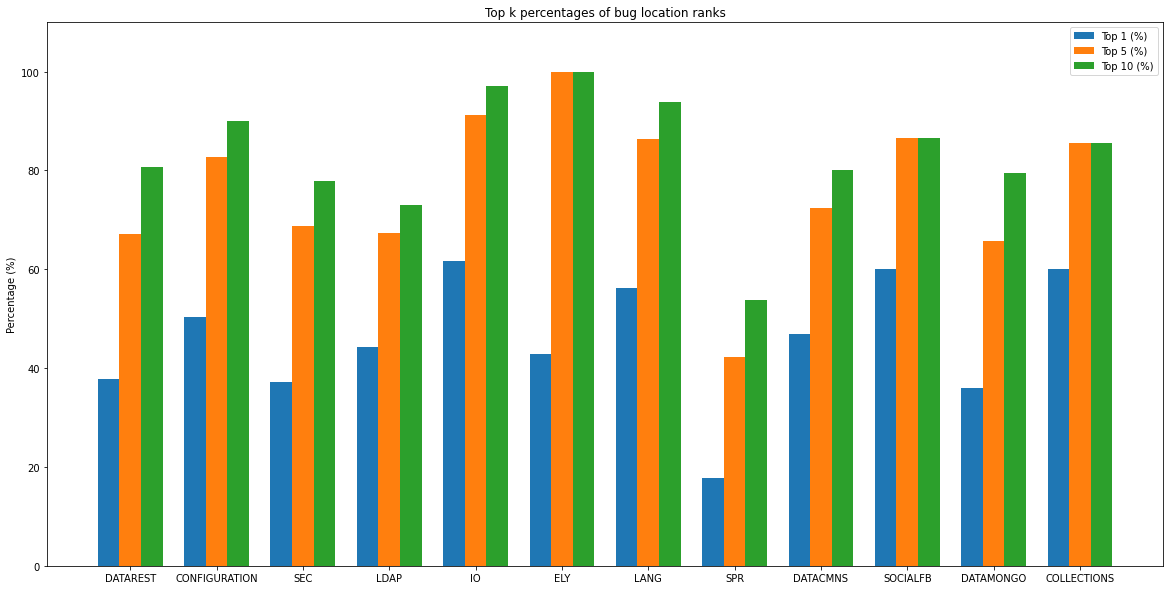

In [404]:
visualize_top_k_percent(all_combined_alpha_performance_table[1])